# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.




In [96]:
!pip install keras
#!pip install tensorflow

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os



# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences
import tensorflow.keras as keras


In [97]:
#use this cell to import additional libraries or define helper functions
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import sequence




## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [98]:
#Load your data into a pandas dataframe here
import pandas as pd
from sklearn.model_selection import train_test_split

In [105]:
# Load the data
df = pd.read_csv("household_power_clean.csv")

# Set the size for data subset
subset_size = int(0.01 * len(df))

# Take a random subset of the data
df_subset = df.sample(n=subset_size, random_state=1)

# Split the data subset 80/20 for train/validation
train_df, val_df = train_test_split(df_subset, test_size=0.2, random_state=1)


In [106]:
#reset the indices for cleanliness
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [107]:
seq_arrays = []
seq_labs = []




In [108]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    seq = train_df.loc[i-seq_length:i-1, feat_cols].values.tolist()
    label = train_df.loc[i+ph, 'Global_active_power']
    seq_arrays.append(seq)
    seq_labs.append(label)


#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [109]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [110]:
seq_arrays.shape

(16358, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: 
Assert statements are Boolean expressions used to inspect whether the given conditions are true; if the conditions are not true, it throws an assertion error. In the above cell, it checks if the seq-arrays and seq_labs variables get the expected values; if not, the assertion statement throws an exception, which means that there is an error in the code.
Using assert statements can be helpful in identifying and fixing bugs and debugging code. By ensuring that given conditions are met, the errors are fixed in the code. Moreover, by detecting the errors early, time and effort can be saved during the debugging process.

## Model Training
We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [111]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = 1
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 5)             140       
                                                                 
 dropout_8 (Dropout)         (None, 30, 5)             0         
                                                                 
 lstm_9 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_9 (Dropout)         (None, 3)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
 activation_4 (Activation)   (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable 

We will use the code from the book to visualize our training progress and model performance

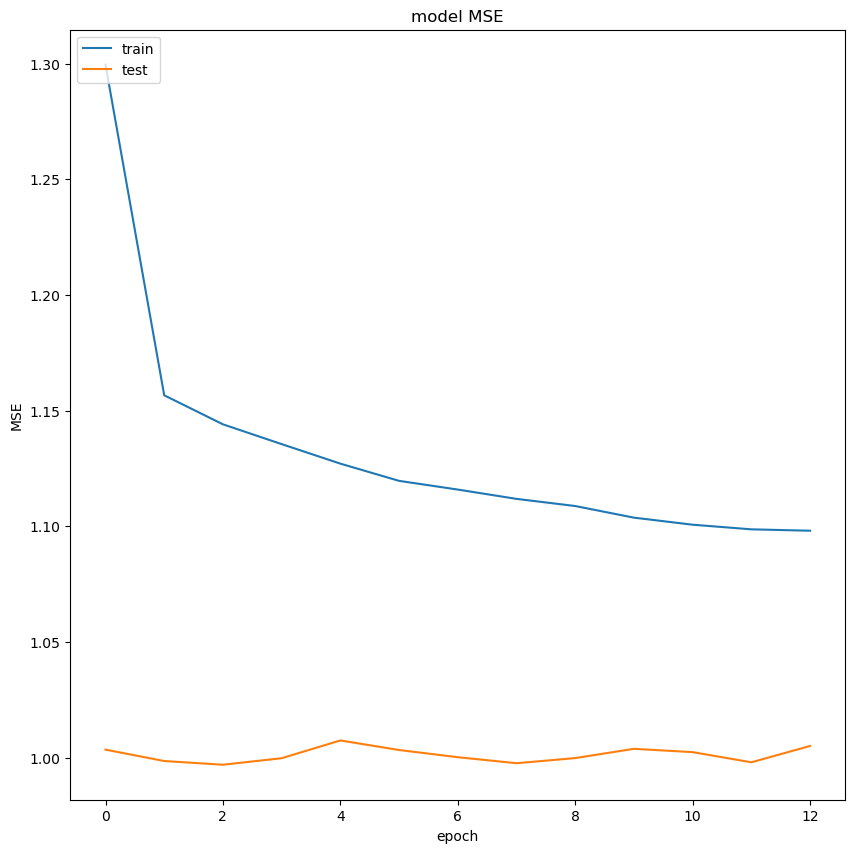

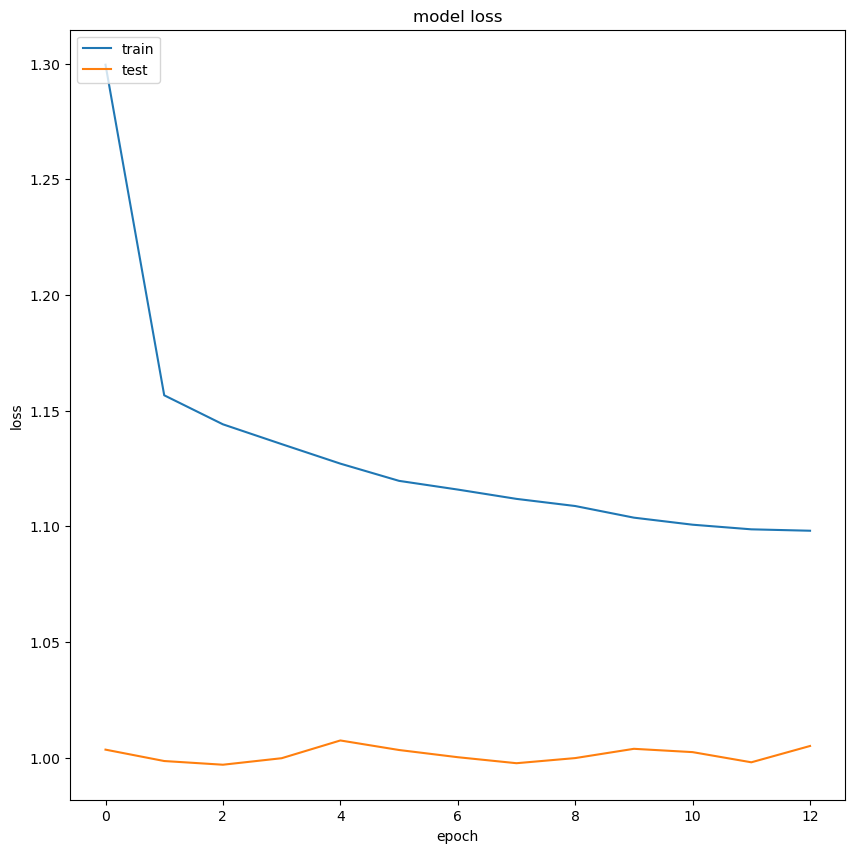

In [113]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: 
The pad_sequences function is a utility from Keras that determines whether pads sequence to a specified length. By setting ‘maxlen’ parameter, this function allows you to specify a maximum length for each sequence in the input. If the sequences are less than maxlen, they will be padded with a value that we specify with ‘padding parameter. It can take ‘pre’ and ‘post’ values to add values before and after the sequence, respectively.

In our case, the 'padding’ parameter should be set to ‘pre’ because we should predict GAP measurement at a fixed time in the future; hence, we need to pad the beginning of the sequence with zeros to make sure that we have sufficient data to make predictions.

In [114]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(seq_length+1, len(val_df)-ph+1):
   
    seq = val_df[feat_cols].iloc[i-seq_length-1:i-1].values.tolist()
 
    lab = val_df[feat_cols].iloc[i+ph-1][0]
    val_arrays.append(seq)
    val_labs.append(lab)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = sequence.pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='post', truncating='post')
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)




We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 1s - loss: 1.1152 - mse: 1.1152 - 864ms/epoch - 7ms/step

MSE: 1.1152069568634033
127/127 [==============================] - 2s 7ms/step


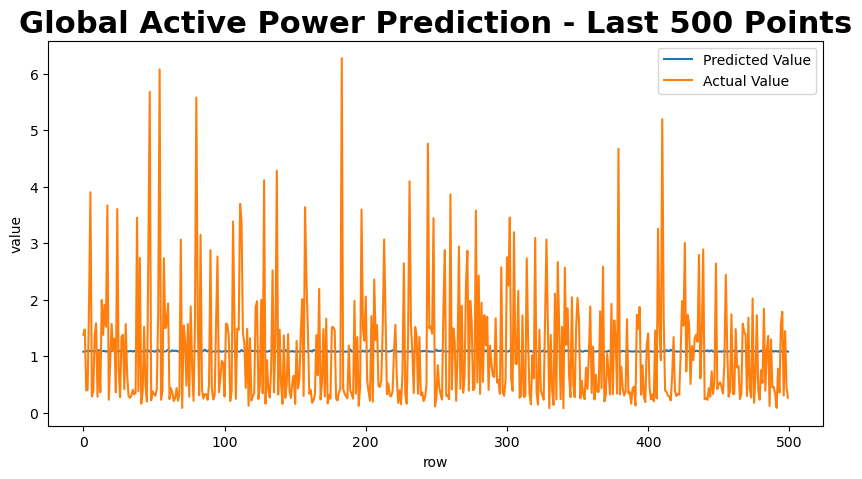

In [115]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)
# Plot the predicted data vs. the actual data

# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")



**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A:The obtained output MSE is 1.1152 and it appears to be low which means that the model is performing better. And in terms of loss curve, it can be known that the model is overfitting since the loss is relatively low and stable. However, to improve, we could try to increase the complexity of the model by adding more layers, or by increasing the dataset size or by trying different neural network architecture.




## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: I would like to try to Add more variables to the input sequences, to capture more information about the household environment.


seq_arrays shape: (16358, 30, 2)
seq_labs shape: (16358, 2)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 5)             160       
                                                                 
 dropout_12 (Dropout)        (None, 30, 5)             0         
                                                                 
 lstm_13 (LSTM)              (None, 3)                 108       
                                                                 
 dropout_13 (Dropout)        (None, 3)                 0         
                                                                 
 dense_6 (Dense)             (None, 2)                 8         
                                                                 
 activation_6 (Activation)   (None, 2)                 0         
                                                            

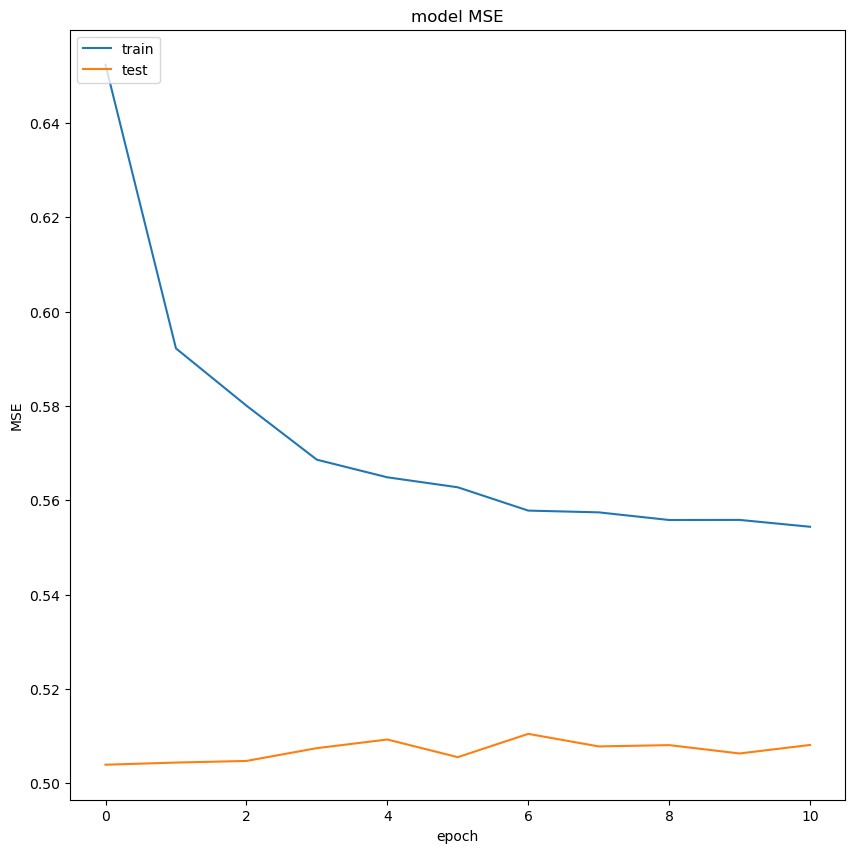

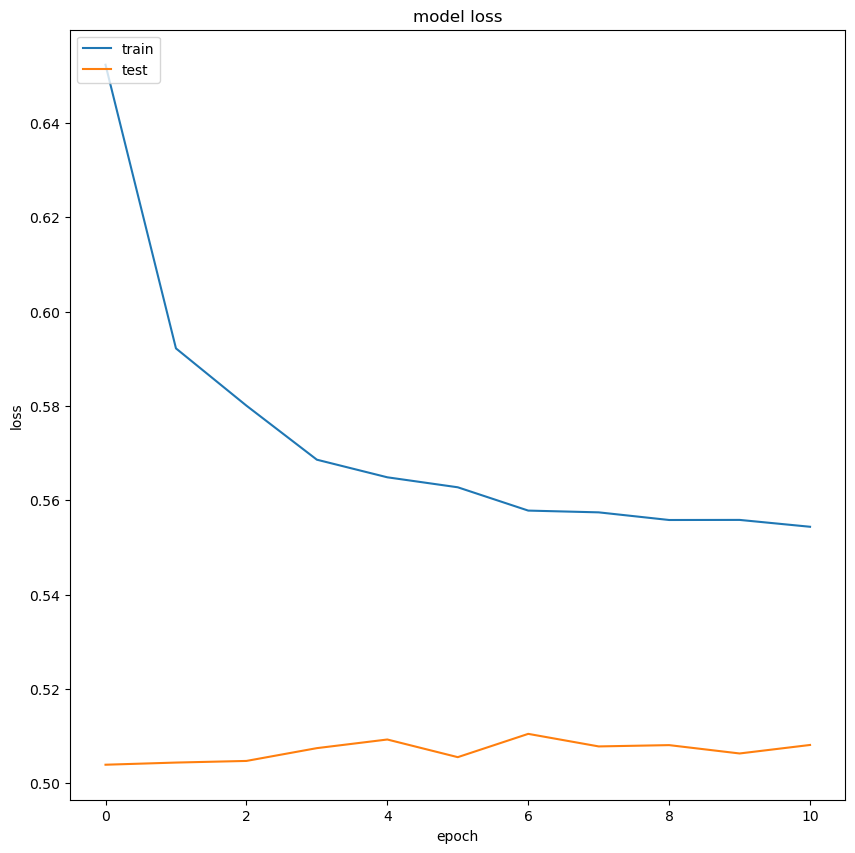

In [129]:
seq_length = 30
ph = 5

feat_cols = ['Global_active_power', 'Global_reactive_power']

#creating list of sequence length GAP readings
seq_arrays = []
seq_labs = []

for i in range(seq_length, len(train_df) - ph):
    seq = train_df[feat_cols].values[i - seq_length:i]
    seq_arrays.append(seq)
    label = train_df[feat_cols].values[i + ph]
    seq_labs.append(label)

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

print(f'seq_arrays shape: {seq_arrays.shape}')
print(f'seq_labs shape: {seq_labs.shape}')

assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,len(feat_cols)))


model_path = 'LSTM_model1.h5'


nb_features = len(feat_cols)
nb_out = len(feat_cols)

model = Sequential()

model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 


model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fitting the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

# summarizing the history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

#summarizing the history for loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


In [130]:
# show me how one or two of your different models perform 
val_arrays = []
val_labs = []
# using the code from the "Validating our model" section above

for i in range(seq_length+1, len(val_df)-ph+1):
    seq = val_df[feat_cols].iloc[i-seq_length-1:i-1].values.tolist()

    lab = val_df[feat_cols].iloc[i+ph-1][0]
    val_arrays.append(seq)
    val_labs.append(lab)
val_arrays = sequence.pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='post', truncating='post')
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The effect of changes on model were dependent on different factors such as the nature of the data, complexity of the model. The padding sequence to a uniform length and reducing the memory requirements make the training process efficient. Nevertheless, truncating sequences result in loss of important data.
If I were trying to optimize model for production, I would try to work with different model architectures, hyperparameters, and processing techniques to determine the best-performing model. I would also perform extensive testing to ensure generalizability and robustness.


**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: When compared with the previous linear regression model, I would say the LSTM model outperformed it in predicting the GAP of a single household with a 5-minute predictive horizon. This is because LSTM is suitable for capturing temporal dependencies in data, which is crucial for time series forecasting tasks. However, linear regression models assume a linear relationship among input and output variables, which is not adaptable for time series data.

Additionally, considering IoT devices, the LST model requires more computational resources than linear regression models, but this is not a critical concern to handle complex machine learning algorithms. Hence, I would prefer the LSTM model for this task as it provides accuracy in predicting the GAP of a single household with a 5-minute predictive horizon and is significant for IoT systems.

In [ ]:
Thankyou!